# SYSNet: Systematics Treatment with Neural Networks

`SYSNet` was developed to tackle the problem of imaging systematic effects, e.g., Galactic dust, in galaxy survey data.

## Installation
We recommend Conda for installation:
```bash
  conda create -q -n sysnet python=3.8 scikit-learn git jupyter ipykernel ipython mpi4py matplotlib
  conda activate sysnet
  conda install pytorch torchvision -c pytorch
  conda install -c conda-forge fitsio healpy absl-py pytables pyyaml
```

## Summary

#### Preprocessing
The input data to `SYSNet` is a tabulated data of the following fields:
1. `hpix`: (int) HEALPix index
2. `label`: (float) number count of galaxies (or quasars) in pixel
3. `fracgood`: (float) weight associated to pixel (the network output will be multiplied by this factor)
4. `features`: (float) array holding imaging properties for pixel

#### Neural Network regression
The `SYSNet` software is called in this step to perform a regression analysis modeling the relationship between `label` and `features`.

#### Postprocessing
The `SYSNet` output will be used to assign appropriate _weights_ to galaxies to account for observational systematics.

## Demo
In the following, we aim to provide a demo of the regression and postprocessing steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys 
import numpy as np
import healpy as hp
import fitsio as ft
sys.path.append('/home/mehdi/github/sysnetdev') # 'Cause SYSNet is not installed yet
from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

### Input data

('label', '>f8')
('hpix', '>i8')
('features', '>f8', (18,))
('fracgood', '>f8')


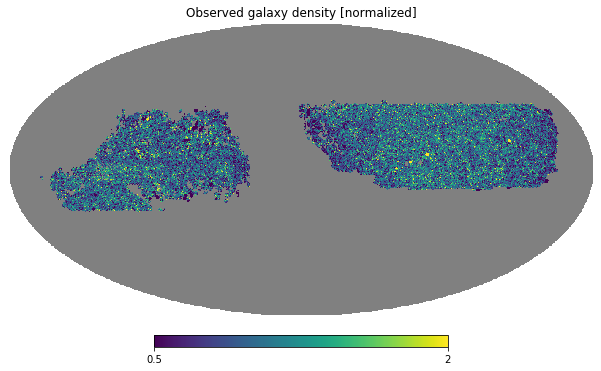

In [12]:
input_ = ft.read('../input/eBOSS.ELG.NGC.DR7.table.fits')  # read tab. data

for array in input_.dtype.descr:
    print(array)
     
# for visualization    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']    

# Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

In [3]:
config = Config('../scripts/config.yaml')   # read config file

In [4]:
config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/model_test',
 'restore_model': None,
 'batch_size': 512,
 'nepochs': 2,
 'nchains': 1,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnn',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.001,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'mse'}

Here is what each keywork means:
```
'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',    # path to the input file
 'output_path': '../output/model_test',                   # dir path to the outputs
 'restore_model': None,                                   # if you want to resume training?
 'batch_size': 512,                                       # size of the mini-batch for training
 'nepochs': 2,                                            # max number of training epochs
 'nchains': 1,                                            # number of chains for the ensemble
 'find_lr': False,                                        # run learning rate finder
 'find_structure': False,                                 # run nn structure finder (brute force)
 'find_l1': False,                                        # run L1 scale finder (brute force)
 'do_kfold': False,                                       # perfom k-fold validation (k=5)
 'do_tar': False,                                         # tar some of the output files 
 'snapshot_ensemble': False,                              # run snapshot ensemble, train one get M for free
 'normalization': 'z-score',                              # normalization rule for the features
 'model': 'dnn',                                          # name of the model, e.g., dnn or dnnp
 'optim': 'adamw',                                        # name of the optimizer
 'scheduler': 'cosann',                                   # name of the scheduler
 'axes': [0, 1, 2],                                       # list of feature indices
 'do_rfe': False,                                         # perform recursive feature elimination (ablation)
 'eta_min': 1e-05,                                        # min learning rate
 'learning_rate': 0.001,                                  # initial learning rate
 'nn_structure': [4, 20],                                 # structure of the neural net (# layers, # units)     
 'l1_alpha': -1.0,                                        # L1 scale, if < 0, it will be ignored
 'loss': 'mse'                                            # name of the loss function, e.g., mse or pnll
```

### Important hyper-parameter, The learning rate!

In [5]:
# let's update some input arguments
config.update('nepochs', 30)
config.update('axes', [i for i in range(18)]) # num of features for this dataset
config.update('batch_size', 4096)

# run learning rate finder
config.update('find_lr', True)
pipeline = SYSNet(config) # perform regression
pipeline.run()

logging in ../output/model_test/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/model_test
restore_model: None
batch_size: 4096
nepochs: 30
nchains: 1
find_lr: True
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnn
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.001
nn_structure: [4, 20]
l1_alpha: -1.0
loss: mse
loss_kwargs: {'reduction': 'sum'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.042 s
data loaded in 0.329 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 18, 1)
base_train_loss: 0.140
base_valid_loss: 0.142
base_test_loss: 0.144
# running hyper-parameter tunning ...
# running l

Learning rate search finished. See the graph with {finder_name}.plot()


SystemExit: LR finder done in 100.810 sec, check out ../output/model_test/loss_vs_lr_0.png

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Check out the produce plot:
![this image](../output/model_test/loss_vs_lr_0.png)

Based on this plot, we should use the initial learning rate around 0.01.

logging in ../output/model_test/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/model_test
restore_model: None
batch_size: 4096
nepochs: 30
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnn
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.01
nn_structure: [4, 20]
l1_alpha: -1.0
loss: mse
loss_kwargs: {'reduction': 'sum'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.019 s
data loaded in 0.148 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 18, 1)
base_train_loss: 0.140
base_valid_loss: 0.142
base_test_loss: 0.144
# running training and evaluation with seed: 2664

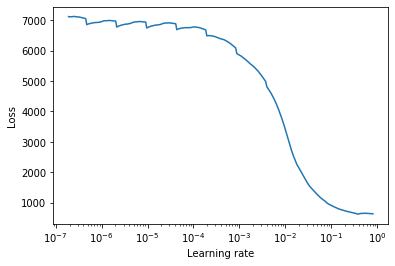

In [6]:
# let's re-train the network with the best learning rate
# monitor validation loss

config.update('find_lr', False) # remember to turn this off
config.update('learning_rate', 0.01)
pipeline = SYSNet(config) # perform regression
pipeline.run()

This plot shows the training and validation loss vs epoch.
![this image](../output/model_test/model_0_2664485226/loss_model_0_2664485226.png)

The baseline model returns 0.144 for the test loss, while the neural network is able to yield a lower value, 0.130.The validation loss is also not showing any sign of over-fitting. 

The code outputs several files:
1. `nn-weights.fits`: this file has healpix index and predicted galaxy count
2. `metrics.npz`: training, validation, test loss and mean and std of features
3. `best.pth.tar`: the best model parameters

In [10]:
tm = TrainedModel('dnn', # name of the model
                  '../output/model_test/model_0_2664485226/best.pth.tar', # best model part 0 seed 2664485226
                  0, # partition of the model
                  (4, 20), # structure of the network
                  18) # num of input features

hpix, npred = tm.forward('../output/model_test/metrics.npz',  # metrics, we need the mean and std of features
                         '../input/eBOSS.ELG.NGC.DR7.table.fits') 
npred = npred / npred.mean()  # normalize
npred = npred.clip(0.5, 2.0)  # avoid extreme predictions


ng_ = np.zeros(12*256*256)
ng_[:] = np.nan
ng_[hpix] = npred

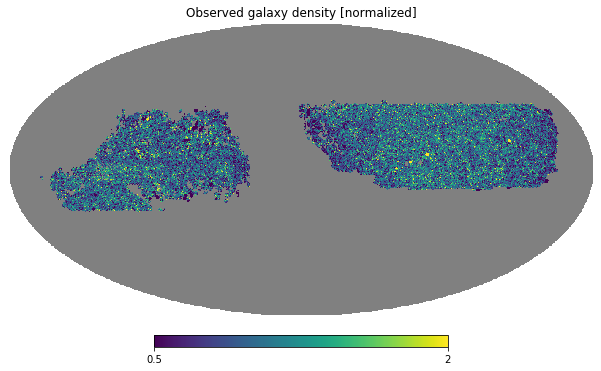

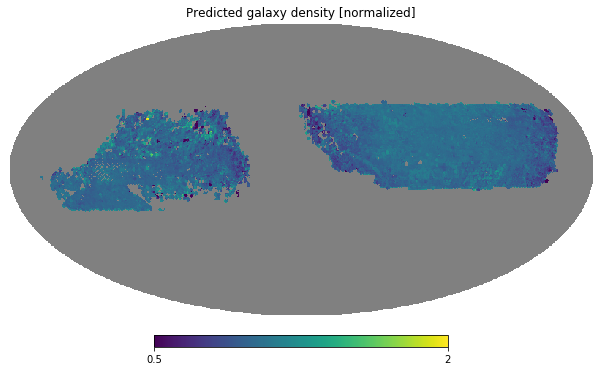

In [14]:
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

hp.mollview(ng_, rot=-85, min=0.5, max=2.0,
            title='Predicted galaxy density [normalized]')

For 30 training epochs, a single fold, and a single chain model, this is not a bad result. In practice, we use 5-fold validation (`do_kfold=True`) and train 20 chains (`nchains=20`) for70-300 epochs.

If you have any questions, feel free to email me at mr095415@ohio.edu.